In [1]:
from google.cloud import bigquery

bq_client = bigquery.Client(project="ai-services-sae")

/home/carolxavier/anaconda3/lib/python3.9/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## HB Payments by Merchant 
### Total count of receivables by merchant

In [4]:
## The merchant status (churned, not-churnign and pre-churn) refers to the Current status of the merchant at the moment of analysis

sql_query_total =  """
WITH ranked_hb_receivables AS (
    SELECT 
      m.user_id AS merchant_id,
      m.cnae,
      COUNT(*) AS count_total_receivables,
      COUNT(CASE WHEN (
        r.minted_at - INTERVAL '3' HOUR <= TIMESTAMP(r.payment_date) + INTERVAL '12' HOUR) 
        THEN 1 END) AS count_until_noon,
      COUNT(CASE WHEN (
        r.minted_at - INTERVAL '3' HOUR > TIMESTAMP(r.payment_date) + INTERVAL '12' HOUR
        AND r.minted_at - INTERVAL '3' HOUR < TIMESTAMP(r.payment_date) + INTERVAL '24' HOUR) 
        THEN 1 END) AS count_after_noon,
      COUNT(CASE WHEN (
        r.minted_at - INTERVAL '3' HOUR >= TIMESTAMP(r.payment_date) + INTERVAL '24' HOUR) 
        THEN 1 END) AS count_delayed,

      SUM(CASE WHEN (
        r.minted_at - INTERVAL '3' HOUR <= TIMESTAMP(r.payment_date) + INTERVAL '12' HOUR) 
        THEN r.amount END) AS amount_until_noon,
      SUM(CASE WHEN (
        r.minted_at - INTERVAL '3' HOUR > TIMESTAMP(r.payment_date) + INTERVAL '12' HOUR
        AND r.minted_at - INTERVAL '3' HOUR < TIMESTAMP(r.payment_date) + INTERVAL '24' HOUR) 
        THEN r.amount END) AS amount_after_noon,
      SUM(CASE WHEN (
        r.minted_at - INTERVAL '3' HOUR >= TIMESTAMP(r.payment_date) + INTERVAL '24' HOUR) 
        THEN r.amount END) AS amount_delayed

 FROM infinitepay-production.maindb.home_bank_receivables r
  INNER JOIN infinitepay-production.maindb.merchants m 
    ON r.document_number = m.document_number

  WHERE TRUE
    AND r.operation in ('credit_anticipated','debit')
    AND r.transaction_hash IS NOT NULL
    AND settlement_method = 'cip'
    AND r.paid_client = true
    AND r.ispb_acquirer = '18189547' --AND r.ispb_issuer = '18189547'
    AND r.payment_date >= '2022-08-19'

  GROUP BY 1,2
),

merchant_status AS (
    SELECT  
        tm.fk_merchant AS merchant_id, 
        MAX(tm.last_transaction_dt_created_at) AS last_sale,
        DATE_DIFF(CURRENT_DATE(), MAX(tm.last_transaction_dt_created_at), DAY) AS churn_time,
        --format_datetime('%Y/%m/%d', t.fk_dt_created_at) as status_day
    FROM `infinitepay-production.dw.fct_transactions_by_merchants` tm
    LEFT JOIN `infinitepay-production.dw.fct_transactions` t
        ON tm.fk_merchant = t.fk_merchant
    WHERE t.fk_status IN (1,5,21)
    GROUP BY 1
),

combined_data AS (
    SELECT 
        r.*,
        CASE 
            WHEN ms.churn_time >= 90 THEN 'churned'
            WHEN ms.churn_time BETWEEN 30 AND 90 THEN 'pre-churn'
            ELSE 'not churning'
        END AS status
    FROM ranked_hb_receivables r
    LEFT JOIN merchant_status ms
        ON r.merchant_id = ms.merchant_id --AND r.day = ms.status_day
)

SELECT 
    * 
FROM combined_data
"""

In [11]:
df_by_merchat = bq_client.query(sql_query_total).to_dataframe()
df_by_merchat.head()

,merchant_id,cnae,count_total_receivables,count_until_noon,count_after_noon,count_delayed,amount_until_noon,amount_after_noon,amount_delayed,status
0,9565885,9602501,77,77,0,0,5018.76,NaN,NaN,not churning
1,8850049,4322301,26,26,0,0,3728.03,NaN,NaN,not churning
2,4741677,8219901,91,87,4,0,4587.13,237.70,NaN,not churning
3,483617,4751201,347,67,16,0,24508.13,21756.32,NaN,not churning
4,3585903,9602502,36,34,2,0,11380.08,2421.84,NaN,not churning


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


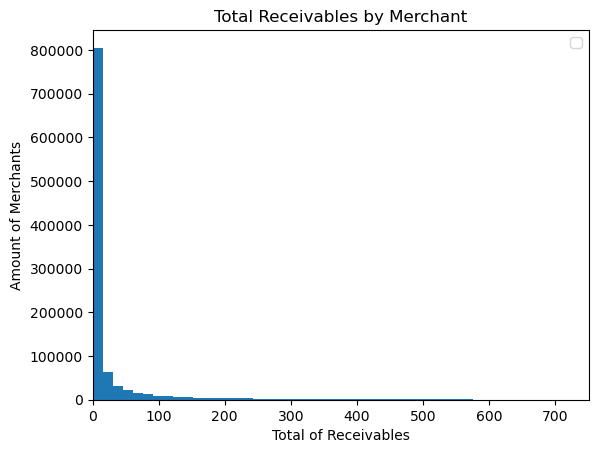

In [12]:
plt.hist(df_by_merchat['count_total_receivables'], bins=120)

plt.title('Total Receivables by Merchant')
plt.xlabel('Total of Receivables')
plt.ylabel('Amount of Merchants')
plt.xlim([0, 750])
plt.legend(loc='upper right')
plt.show()

In [13]:
receivables_1 = (df_by_merchat['count_total_receivables'] == 1).sum()
print(f"# of merchants with 1 receivable: {receivables_1}")

receivables_10 = (df_by_merchat['count_total_receivables'] <= 10).sum()
print(f"# of merchants with less than 10 receivables: {receivables_10}")

receivables_50 = (df_by_merchat['count_total_receivables'] <= 50).sum()
print(f"# of merchants with less than 50 receivables: {receivables_50}")

receivables_50 = (df_by_merchat['count_total_receivables'] >= 50).sum()
print(f"# of merchants with more than 50 receivables: {receivables_50}")

receivables_100 = (df_by_merchat['count_total_receivables'] <= 100).sum()
print(f"# of merchants with less than 100 receivables: {receivables_100}")

receivables_100_plus = (df_by_merchat['count_total_receivables'] >= 100).sum()
print(f"# of merchants with more than 100 receivables: {receivables_100}")

receivables_1000 = (df_by_merchat['count_total_receivables'] > 1000).sum()
print(f"# of merchants with less than 1000 receivables: {receivables_1000}")

# of merchants with 1 receivable: 343033
# of merchants with less than 10 receivables: 748960
# of merchants with less than 50 receivables: 908056
# of merchants with more than 50 receivables: 132177
# of merchants with less than 100 receivables: 956114
# of merchants with more than 100 receivables: 956114
# of merchants with less than 1000 receivables: 1062


### Merchants with 10 or more Receivables

In [68]:
df_by_merchat_10 = df_by_merchat[df_by_merchat['count_total_receivables'] >= 10]
df_by_merchat_10.head()

,merchant_id,cnae,count_total_receivables,count_until_noon,count_after_noon,count_delayed,amount_until_noon,amount_after_noon,amount_delayed,status
0,9565885,9602501,77,77,0,0,5018.76,NaN,NaN,not churning
1,8850049,4322301,26,26,0,0,3728.03,NaN,NaN,not churning
2,4741677,8219901,91,87,4,0,4587.13,237.70,NaN,not churning
3,483617,4751201,347,67,16,0,24508.13,21756.32,NaN,not churning
4,3585903,9602502,36,34,2,0,11380.08,2421.84,NaN,not churning


In [69]:
#Calculate the probability of payment delay PER MERCHANT

df_by_merchat_10['payment_delay'] = df_by_merchat_10['count_after_noon'] + df_by_merchat_10['count_delayed']

df_by_merchat_10['payment_total'] = df_by_merchat_10['count_until_noon'] + df_by_merchat_10['count_after_noon'] + df_by_merchat_10['count_delayed']

df_by_merchat_10['probability_of_delay'] = df_by_merchat_10['payment_delay'] / df_by_merchat_10['payment_total']

df_by_merchat_10.head()

/tmp/ipykernel_540223/4110911500.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_by_merchat_10['payment_delay'] = df_by_merchat_10['count_after_noon'] + df_by_merchat_10['count_delayed']
/tmp/ipykernel_540223/4110911500.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_by_merchat_10['payment_total'] = df_by_merchat_10['count_until_noon'] + df_by_merchat_10['count_after_noon'] + df_by_merchat_10['count_delayed']
/tmp/ipykernel_540223/4110911500.py:7: SettingWithCopyWarning: 
A value is trying to 

,merchant_id,cnae,count_total_receivables,count_until_noon,count_after_noon,count_delayed,amount_until_noon,amount_after_noon,amount_delayed,status,payment_delay,payment_total,probability_of_delay
0,9565885,9602501,77,77,0,0,5018.76,NaN,NaN,not churning,0,77,0.0
1,8850049,4322301,26,26,0,0,3728.03,NaN,NaN,not churning,0,26,0.0
2,4741677,8219901,91,87,4,0,4587.13,237.70,NaN,not churning,4,91,0.043956
3,483617,4751201,347,67,16,0,24508.13,21756.32,NaN,not churning,16,83,0.192771
4,3585903,9602502,36,34,2,0,11380.08,2421.84,NaN,not churning,2,36,0.055556


In [56]:
# Count the number of rows with probability_of_delay equal to zero by group

statuses = df_by_merchat_10['status'].unique()

for status in statuses:
    subset = df_by_merchat_10[df_by_merchat_10['status'] == status]
    count_zero_delay = (subset['probability_of_delay'] == 0).sum()
    count_total = (subset['count_total_receivables']).sum()
    print(f"{status}: amount of zeros - {count_zero_delay}, amount of receivables - {count_total}, ratio - {(count_zero_delay / count_total):.4f}")

not churning: amount of zeros - 38434, amount of receivables - 27865169, ratio - 0.0014
pre-churn: amount of zeros - 3249, amount of receivables - 1721298, ratio - 0.0019
churned: amount of zeros - 2967, amount of receivables - 1384147, ratio - 0.0021


In [76]:
group_mean = df_by_merchat_10.groupby('status')['probability_of_delay'].median()

formatted_series = group_mean.apply(lambda x: f"{x * 100:.2f}%")

print(formatted_series)

status
churned         12.73%
not churning    10.64%
pre-churn       14.47%
Name: probability_of_delay, dtype: object


/tmp/ipykernel_540223/3297019993.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y='probability_of_delay', data=df_by_merchat_10, palette='Set1')


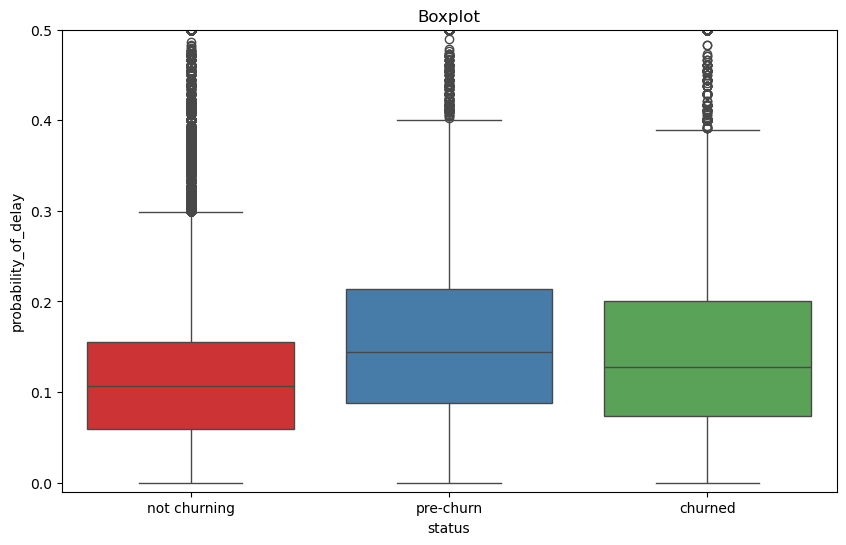

In [70]:
# BoxPlot 

plt.figure(figsize=(10,6))
sns.boxplot(x='status', y='probability_of_delay', data=df_by_merchat_10, palette='Set1')
plt.title('Boxplot')
plt.ylabel('probability_of_delay')
plt.xlabel('status')
plt.ylim([-0.01, 0.5])
plt.show()

/tmp/ipykernel_540223/2280832192.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='status', y='probability_of_delay', data=df_by_merchat_10, palette='Set1')


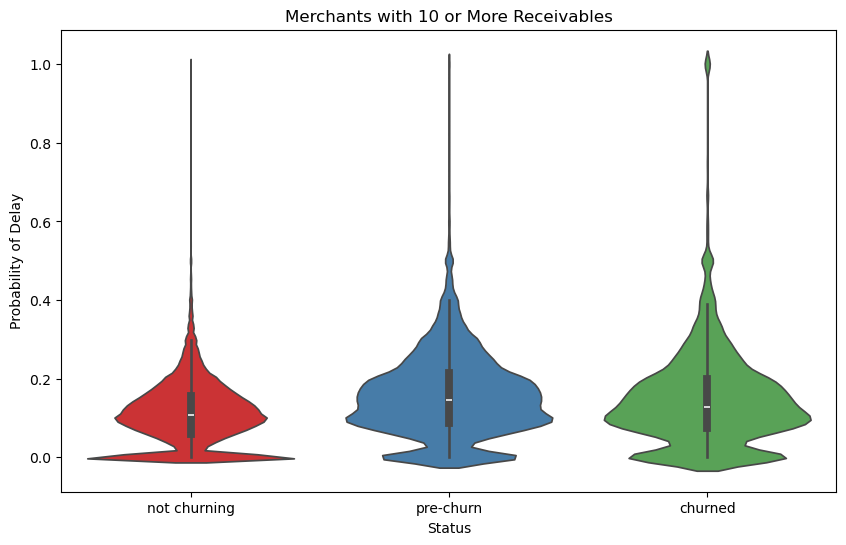

In [71]:
#Violin Plot 

plt.figure(figsize=(10, 6))
sns.violinplot(x='status', y='probability_of_delay', data=df_by_merchat_10, palette='Set1')
plt.title('Merchants with 10 or More Receivables')
plt.ylabel('Probability of Delay')
plt.xlabel('Status')
plt.show()

In [165]:
df_churned = df_by_merchat_10[df_by_merchat_10['status'] == 'churned']
df_churned.head()

,merchant_id,cnae,count_total_receivables,count_until_noon,count_after_noon,count_delayed,amount_until_noon,amount_after_noon,amount_delayed,status,payment_delay,payment_total,probability_of_delay
27,5077832,4530703,121,97,24,0,66881.36,26079.91,NaN,churned,24,121,0.198347
50,1660920,7911200,139,50,5,0,162239.33,17091.57,NaN,churned,5,55,0.090909
57,934102,8630504,378,217,45,0,155171.55,53201.82,NaN,churned,45,262,0.171756
58,284992,5611203,422,209,23,0,19425.28,2990.77,NaN,churned,23,232,0.099138
104,1091924,7990200,171,63,20,0,25278.60,8996.91,NaN,churned,20,83,0.240964


### Merchants with 50 or more Receivables

In [61]:
df_by_merchat_50 = df_by_merchat[df_by_merchat['count_total_receivables'] >= 50]
df_by_merchat_50.head()

,merchant_id,cnae,count_total_receivables,count_until_noon,count_after_noon,count_delayed,amount_until_noon,amount_after_noon,amount_delayed,status
0,9565885,9602501,77,77,0,0,5018.76,NaN,NaN,not churning
2,4741677,8219901,91,87,4,0,4587.13,237.70,NaN,not churning
3,483617,4751201,347,67,16,0,24508.13,21756.32,NaN,not churning
5,5436568,4723700,85,78,7,0,11982.55,529.95,NaN,not churning
7,1095859,4781400,106,67,9,0,103002.78,20651.35,NaN,not churning


In [62]:
df_by_merchat_50['payment_delay'] = df_by_merchat_50['count_after_noon'] + df_by_merchat_50['count_delayed']

df_by_merchat_50['payment_total'] = df_by_merchat_50['count_until_noon'] + df_by_merchat_50['count_after_noon'] + df_by_merchat_50['count_delayed']

df_by_merchat_50['probability_of_delay'] = df_by_merchat_50['payment_delay'] / df_by_merchat_50['payment_total']

df_by_merchat_50.head()

/tmp/ipykernel_540223/1026473145.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_by_merchat_50['payment_delay'] = df_by_merchat_50['count_after_noon'] + df_by_merchat_50['count_delayed']
/tmp/ipykernel_540223/1026473145.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_by_merchat_50['payment_total'] = df_by_merchat_50['count_until_noon'] + df_by_merchat_50['count_after_noon'] + df_by_merchat_50['count_delayed']
/tmp/ipykernel_540223/1026473145.py:5: SettingWithCopyWarning: 
A value is trying to 

,merchant_id,cnae,count_total_receivables,count_until_noon,count_after_noon,count_delayed,amount_until_noon,amount_after_noon,amount_delayed,status,payment_delay,payment_total,probability_of_delay
0,9565885,9602501,77,77,0,0,5018.76,NaN,NaN,not churning,0,77,0.0
2,4741677,8219901,91,87,4,0,4587.13,237.70,NaN,not churning,4,91,0.043956
3,483617,4751201,347,67,16,0,24508.13,21756.32,NaN,not churning,16,83,0.192771
5,5436568,4723700,85,78,7,0,11982.55,529.95,NaN,not churning,7,85,0.082353
7,1095859,4781400,106,67,9,0,103002.78,20651.35,NaN,not churning,9,76,0.118421


In [64]:
# Count the number of rows with probability_of_delay equal to zero by group

statuses = df_by_merchat_50['status'].unique()

for status in statuses:
    subset = df_by_merchat_50[df_by_merchat_50['status'] == status]
    count_zero_delay = (subset['probability_of_delay'] == 0).sum()
    count_total = (subset['count_total_receivables']).sum()
    print(f"{status}: amount of zeros - {count_zero_delay}, amount of receivables - {count_total}, ratio - {(count_zero_delay / count_total):.4f}")

not churning: amount of zeros - 5470, amount of receivables - 24825372, ratio - 0.0002
pre-churn: amount of zeros - 93, amount of receivables - 1240774, ratio - 0.0001
churned: amount of zeros - 351, amount of receivables - 1081424, ratio - 0.0003


In [75]:
group_mean = df_by_merchat_50.groupby('status')['probability_of_delay'].median()

formatted_series = group_mean.apply(lambda x: f"{x * 100:.2f}%")

print(formatted_series)

status
churned         12.61%
not churning    11.24%
pre-churn       14.29%
Name: probability_of_delay, dtype: object


/tmp/ipykernel_540223/3335194693.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y='probability_of_delay', data=df_by_merchat_50, palette='Set1')


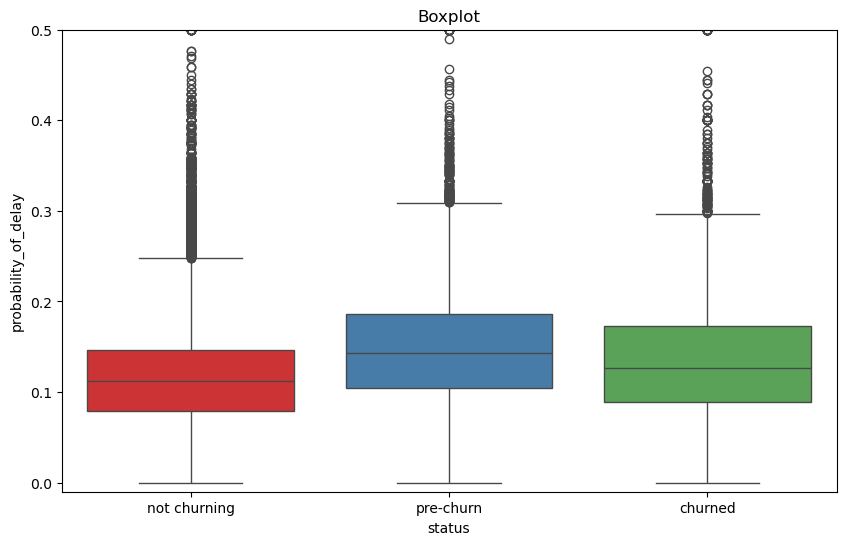

In [65]:
# BoxPlot 

plt.figure(figsize=(10,6))
sns.boxplot(x='status', y='probability_of_delay', data=df_by_merchat_50, palette='Set1')
plt.title('Boxplot')
plt.ylabel('probability_of_delay')
plt.xlabel('status')
plt.ylim([-0.01, 0.5])
plt.show()

/tmp/ipykernel_540223/1862305458.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='status', y='probability_of_delay', data=df_by_merchat_50, palette='Set1')


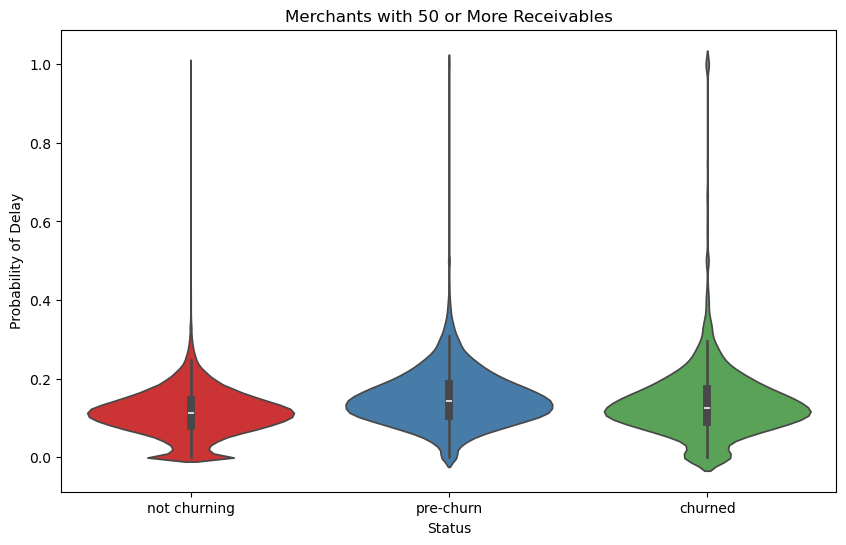

In [72]:
#Violin Plot 

plt.figure(figsize=(10, 6))
sns.violinplot(x='status', y='probability_of_delay', data=df_by_merchat_50, palette='Set1')
plt.title('Merchants with 50 or More Receivables')
plt.ylabel('Probability of Delay')
plt.xlabel('Status')
plt.show()

### Merchants with 100 or more Receivables

In [49]:
df_by_merchat_100 = df_by_merchat[df_by_merchat['count_total_receivables'] >= 100]
df_by_merchat_100.head()

,merchant_id,cnae,count_total_receivables,count_until_noon,count_after_noon,count_delayed,amount_until_noon,amount_after_noon,amount_delayed,status
3,483617,4751201,347,67,16,0,24508.13,21756.32,NaN,not churning
7,1095859,4781400,106,67,9,0,103002.78,20651.35,NaN,not churning
9,319876,3299004,243,174,31,0,103532.01,22450.55,NaN,not churning
11,2683110,9512600,198,168,30,0,51755.10,16162.90,NaN,pre-churn
12,2310681,4781400,138,45,8,0,16671.30,1471.34,NaN,not churning


In [50]:
#Calculate the probability of payment delay PER MERCHANT

df_by_merchat_100['payment_delay'] = df_by_merchat_100['count_after_noon'] + df_by_merchat_100['count_delayed']

df_by_merchat_100['payment_total'] = df_by_merchat_100['count_until_noon'] + df_by_merchat_100['count_after_noon'] + df_by_merchat_100['count_delayed']

df_by_merchat_100['probability_of_delay'] = df_by_merchat_100['payment_delay'] / df_by_merchat_100['payment_total']

df_by_merchat_100.head()

/tmp/ipykernel_540223/1764788771.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_by_merchat_100['payment_delay'] = df_by_merchat_100['count_after_noon'] + df_by_merchat_100['count_delayed']
/tmp/ipykernel_540223/1764788771.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_by_merchat_100['payment_total'] = df_by_merchat_100['count_until_noon'] + df_by_merchat_100['count_after_noon'] + df_by_merchat_100['count_delayed']
/tmp/ipykernel_540223/1764788771.py:7: SettingWithCopyWarning: 
A value is try

,merchant_id,cnae,count_total_receivables,count_until_noon,count_after_noon,count_delayed,amount_until_noon,amount_after_noon,amount_delayed,status,payment_delay,payment_total,probability_of_delay
3,483617,4751201,347,67,16,0,24508.13,21756.32,NaN,not churning,16,83,0.192771
7,1095859,4781400,106,67,9,0,103002.78,20651.35,NaN,not churning,9,76,0.118421
9,319876,3299004,243,174,31,0,103532.01,22450.55,NaN,not churning,31,205,0.15122
11,2683110,9512600,198,168,30,0,51755.10,16162.90,NaN,pre-churn,30,198,0.151515
12,2310681,4781400,138,45,8,0,16671.30,1471.34,NaN,not churning,8,53,0.150943


In [51]:
# Count the number of rows with probability_of_delay equal to zero by group

statuses = df_by_merchat_100['status'].unique()

for status in statuses:
    subset = df_by_merchat_100[df_by_merchat_100['status'] == status]
    count_zero_delay = (subset['probability_of_delay'] == 0).sum()
    count_total = (subset['count_total_receivables']).sum()
    print(f"{status}: amount of zeros - {count_zero_delay}, amount of receivables - {count_total}, ratio - {(count_zero_delay / count_total):.4f}")

not churning: amount of zeros - 1504, amount of receivables - 21790420, ratio - 0.0001
pre-churn: amount of zeros - 23, amount of receivables - 1014127, ratio - 0.0000
churned: amount of zeros - 146, amount of receivables - 878326, ratio - 0.0002


In [74]:
group_mean = df_by_merchat_100.groupby('status')['probability_of_delay'].median()

formatted_series = group_mean.apply(lambda x: f"{x * 100:.2f}%")

print(formatted_series)

status
churned         12.21%
not churning    11.19%
pre-churn       13.70%
Name: probability_of_delay, dtype: object


/tmp/ipykernel_540223/2859583203.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y='probability_of_delay', data=df_by_merchat_10, palette='Set1')


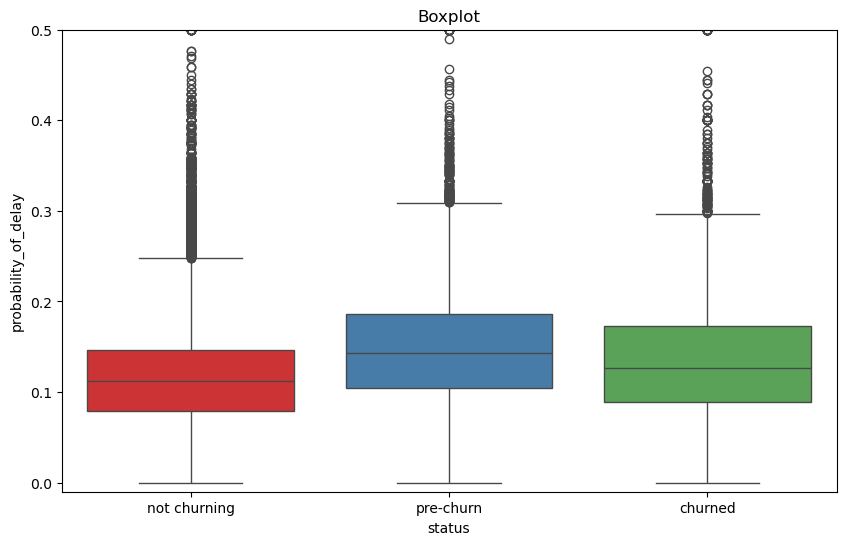

In [52]:
#BoxPlot 

plt.figure(figsize=(10,6))
sns.boxplot(x='status', y='probability_of_delay', data=df_by_merchat_10, palette='Set1')
plt.title('Boxplot')
plt.ylabel('probability_of_delay')
plt.xlabel('status')
plt.ylim([-0.01, 0.5])
plt.show()

/tmp/ipykernel_540223/1380160981.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='status', y='probability_of_delay', data=df_by_merchat_100, palette='Set1')


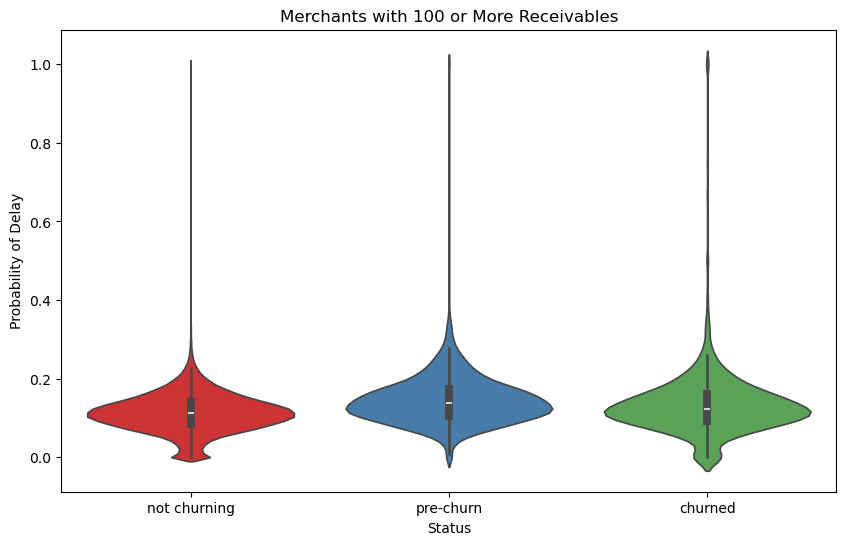

In [73]:
#Violin Plot with Zeros

plt.figure(figsize=(10, 6))
sns.violinplot(x='status', y='probability_of_delay', data=df_by_merchat_100, palette='Set1')
plt.title('Merchants with 100 or More Receivables')
plt.ylabel('Probability of Delay')
plt.xlabel('Status')
plt.show()

## HB Payments by Merchant by Day 

In [77]:
## The merchant status (churned, not-churnign and pre-churn) refers to the Current status of the merchant at the moment of analysis

sql_query_by_day = """
WITH ranked_hb_receivables AS (
    SELECT 
      m.user_id AS merchant_id,
      m.cnae,
      format_datetime('%Y/%m/%d', r.payment_date - INTERVAL '3' HOUR) as day,
      COUNT(CASE WHEN (
        r.minted_at - INTERVAL '3' HOUR <= TIMESTAMP(r.payment_date) + INTERVAL '12' HOUR) 
        THEN 1 END) AS count_until_noon,
      COUNT(CASE WHEN (
        r.minted_at - INTERVAL '3' HOUR > TIMESTAMP(r.payment_date) + INTERVAL '12' HOUR
        AND r.minted_at - INTERVAL '3' HOUR < TIMESTAMP(r.payment_date) + INTERVAL '24' HOUR) 
        THEN 1 END) AS count_after_noon,
      COUNT(CASE WHEN (
        r.minted_at - INTERVAL '3' HOUR >= TIMESTAMP(r.payment_date) + INTERVAL '24' HOUR) 
        THEN 1 END) AS count_delayed,

      SUM(CASE WHEN (
        r.minted_at - INTERVAL '3' HOUR <= TIMESTAMP(r.payment_date) + INTERVAL '12' HOUR) 
        THEN r.amount END) AS amount_until_noon,
      SUM(CASE WHEN (
        r.minted_at - INTERVAL '3' HOUR > TIMESTAMP(r.payment_date) + INTERVAL '12' HOUR
        AND r.minted_at - INTERVAL '3' HOUR < TIMESTAMP(r.payment_date) + INTERVAL '24' HOUR) 
        THEN r.amount END) AS amount_after_noon,
      SUM(CASE WHEN (
        r.minted_at - INTERVAL '3' HOUR >= TIMESTAMP(r.payment_date) + INTERVAL '24' HOUR) 
        THEN r.amount END) AS amount_delayed

 FROM infinitepay-production.maindb.home_bank_receivables r
  INNER JOIN infinitepay-production.maindb.merchants m 
    ON r.document_number = m.document_number

  WHERE TRUE
    AND r.operation in ('credit_anticipated','debit')
    AND r.transaction_hash IS NOT NULL
    AND settlement_method = 'cip'
    AND r.paid_client = true
    AND r.ispb_acquirer = '18189547' --AND r.ispb_issuer = '18189547'
    AND r.payment_date >= '2022-08-19'

  GROUP BY 1,2,3
),

merchant_status AS (
    SELECT  
        tm.fk_merchant AS merchant_id, 
        MAX(tm.last_transaction_dt_created_at) AS last_sale,
        DATE_DIFF(CURRENT_DATE(), MAX(tm.last_transaction_dt_created_at), DAY) AS churn_time,
        format_datetime('%Y/%m/%d', t.fk_dt_created_at) as status_day
    FROM `infinitepay-production.dw.fct_transactions_by_merchants` tm
    LEFT JOIN `infinitepay-production.dw.fct_transactions` t
        ON tm.fk_merchant = t.fk_merchant
    WHERE t.fk_status IN (1,5,21)
    GROUP BY 1, 4
),

combined_data AS (
    SELECT 
        r.day,
        r.merchant_id,
        r.cnae,
        COUNT(CASE WHEN (r.count_until_noon > 0) THEN 1 END) AS paid_until_noon,
        COUNT(CASE WHEN (r.count_after_noon > 0) THEN 1 END) AS paid_after_noon,
        COUNT(CASE WHEN (r.count_delayed > 0) THEN 1 END) AS paid_delayed,
        r.amount_until_noon,
        r.amount_after_noon,
        r.amount_delayed,
        CASE 
            WHEN ms.churn_time >= 90 THEN 'churned'
            WHEN ms.churn_time BETWEEN 30 AND 90 THEN 'pre-churn'
            ELSE 'not churning'
        END AS status
    FROM ranked_hb_receivables r
    LEFT JOIN merchant_status ms
        ON r.merchant_id = ms.merchant_id AND r.day = ms.status_day
    GROUP BY 1,2,3,7,8,9,10
)

SELECT * FROM combined_data
ORDER BY day;
"""

In [78]:
df = bq_client.query(sql_query_by_day).to_dataframe()
df.head()

,day,merchant_id,cnae,paid_until_noon,paid_after_noon,paid_delayed,amount_until_noon,amount_after_noon,amount_delayed,status
0,2022/08/18,221723,4752100,0,1,0,NaN,53.44,NaN,churned
1,2022/08/18,24752,4741500,1,1,0,567.34,157.41,NaN,churned
2,2022/08/18,12418,4744005,0,0,0,NaN,NaN,NaN,not churning
3,2022/08/18,117412,9602502,0,0,0,NaN,NaN,NaN,not churning
4,2022/08/18,112523,4744099,0,0,0,NaN,NaN,NaN,pre-churn


In [81]:
#Calculate the probability of a day having a payment delay for HB receivables

df['delayed'] = ((df['paid_after_noon'] == 1) | (df['paid_delayed'] == 1)).astype(int)

total = len(df)

total_delayes = df['delayed'].sum()

probability_of_delay = total_delayes / total

print(f"{'chance of delay in payment'}: {probability_of_delay * 100:.2f}%")

chance of delay in payment: 13.46%


In [82]:
#Calculate the probability of the merchant having a day with a receivable payment being delayed

df['payment_delayed'] = ((df['paid_after_noon'] == 1) | (df['paid_delayed'] == 1)).astype(int)

df_probability = df.groupby('merchant_id')['payment_delayed'].mean().reset_index()

df_probability.columns = ['merchant_id', 'probability_of_delay']

df_probability.head()

,merchant_id,probability_of_delay
0,2,0.100000
1,5,0.000000
2,7,0.142857
3,15,0.053571
4,19,0.200000


In [83]:
last_status = df.groupby('merchant_id')['status'].last().reset_index()

final_df = pd.merge(df_probability, last_status, on='merchant_id', how='left')
final_df.head()

,merchant_id,probability_of_delay,status
0,2,0.100000,not churning
1,5,0.000000,pre-churn
2,7,0.142857,not churning
3,15,0.053571,not churning
4,19,0.200000,not churning


In [93]:
count_zeros = (final_df['probability_of_delay'] == 0).sum()
print(f"# of merchants with zero probability of delay: {count_zeros}")

# of merchants with zero probability of delay: 611825


In [101]:
total_receivables = df_by_merchat[['merchant_id','count_total_receivables']]

df_probability_total = pd.merge(final_df, total_receivables, on='merchant_id', how='left')
df_probability_total.head()

,merchant_id,probability_of_delay,status,count_total_receivables
0,2,0.100000,not churning,24
1,5,0.000000,pre-churn,7
2,7,0.142857,not churning,7
3,15,0.053571,not churning,63
4,19,0.200000,not churning,6


In [122]:
count_one = (df_probability_total['count_total_receivables'] == 1).sum()
print(f"# of merchants with only one receivable: {count_one}")

count_less_10 = (df_probability_total['count_total_receivables'] < 10).sum()
print(f"# of merchants with zero probability of delay: {count_less_10}")

df_zeros = df_probability_total[df_probability_total['probability_of_delay'] == 0]
df_zeros.sort_values(by=['count_total_receivables'], ascending=False)

# of merchants with only one receivable: 343033
# of merchants with zero probability of delay: 734892


,merchant_id,probability_of_delay,status,count_total_receivables
98509,849989,0.0,not churning,577
136677,1309124,0.0,not churning,454
169037,1711722,0.0,churned,453
165861,1663975,0.0,churned,447
32265,237275,0.0,churned,441
...,...,...,...,...
417564,4372502,0.0,churned,1
417565,4372509,0.0,not churning,1
417567,4372535,0.0,churned,1
1038729,12382769,0.0,not churning,1


In [160]:
# Filter the merchants with less than 100 receivables and probability_of_delay equal zero
## In other words, filter the merchants that were never impacted by payment delay even though they are very active

df_filtered_total = df_probability_total[(df_probability_total['count_total_receivables'] >= 10)]
df_filtered_total_probab = df_probability_total[(df_probability_total['count_total_receivables'] >= 10) & (df_probability_total['probability_of_delay'] != 0)]

/tmp/ipykernel_540223/2466418089.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y='probability_of_delay', data=df_filtered_total, order=group_order, palette=palette_dict)


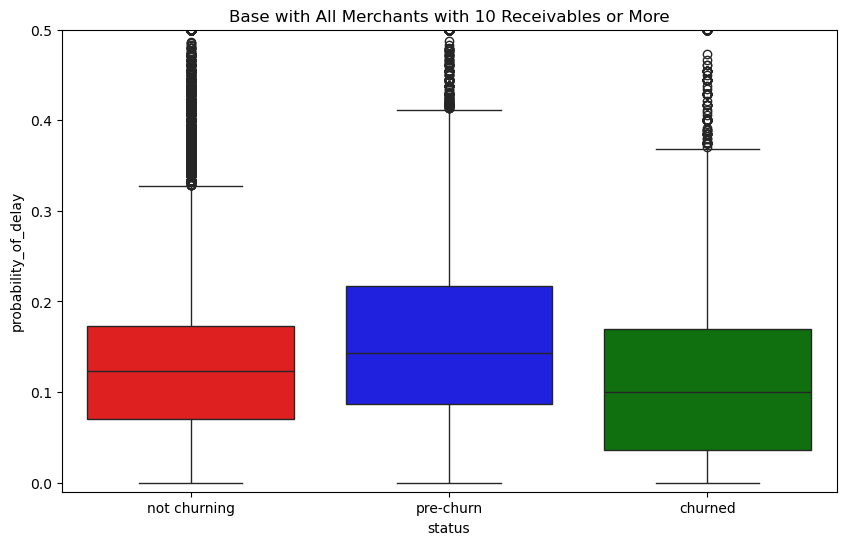

/tmp/ipykernel_540223/2466418089.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y='probability_of_delay', data=df_filtered_total_probab,order=group_order, palette=palette_dict)


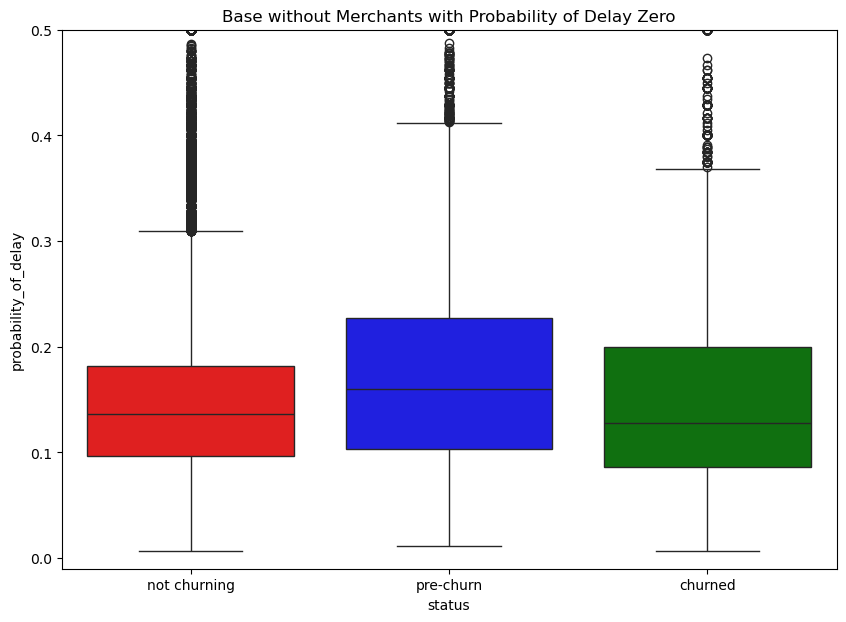

In [164]:
palette_dict = {'churned': 'green', 'not churning': 'red', 'pre-churn': 'blue'}
group_order = ['not churning', 'pre-churn', 'churned'] 

# Base with probability of delay zero 
plt.figure(figsize=(10,6))
sns.boxplot(x='status', y='probability_of_delay', data=df_filtered_total, order=group_order, palette=palette_dict)
plt.title('Base with All Merchants with 10 Receivables or More')
plt.ylabel('probability_of_delay')
plt.xlabel('status')
plt.ylim([-0.01, 0.5])
plt.show()


# Base without probability of delay zero
plt.figure(figsize=(10,7))
sns.boxplot(x='status', y='probability_of_delay', data=df_filtered_total_probab,order=group_order, palette=palette_dict)
plt.title('Base without Merchants with Probability of Delay Zero')
plt.ylabel('probability_of_delay')
plt.xlabel('status')
plt.ylim([-0.01, 0.5])
plt.show()

/tmp/ipykernel_540223/2931882207.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y='amount_after_noon', data=df_by_merchat_100, palette='Set1')


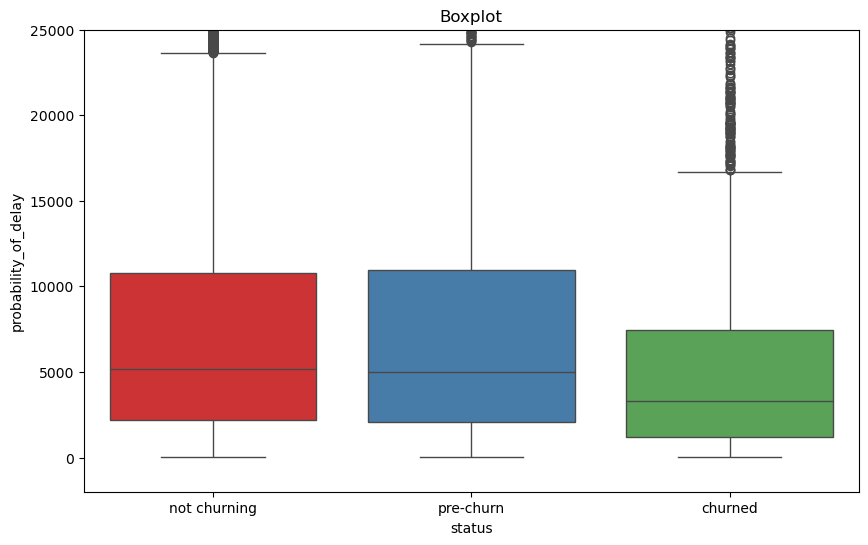

/tmp/ipykernel_540223/2931882207.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y='amount_after_noon', data=df_by_merchat_50, palette='Set1')


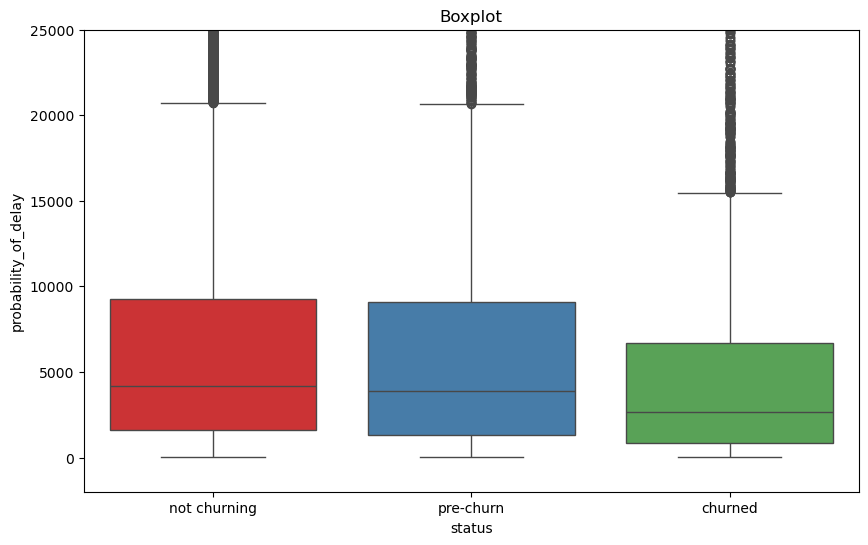

In [182]:
plt.figure(figsize=(10,6))
sns.boxplot(x='status', y='amount_after_noon', data=df_by_merchat_100, palette='Set1')
plt.title('Boxplot')
plt.ylabel('probability_of_delay')
plt.xlabel('status')
plt.ylim([-2000,25000])
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='status', y='amount_after_noon', data=df_by_merchat_50, palette='Set1')
plt.title('Boxplot')
plt.ylabel('probability_of_delay')
plt.xlabel('status')
plt.ylim([-2000,25000])
plt.show()